# Create a dataset of non-digits from MNIST by creating adversarial examples using FGSM

Can we create a dataset of non-digits that can be used to train a model that tells us if an image has been designed to fool our classifier.

https://arxiv.org/abs/1412.6572

https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from torchvision.transforms.functional import to_pil_image, to_tensor, normalize
from nbdev_quick import *
nbdev_quick.init()

In [2]:
img0_path=mnist_path/'training/0/210.png'
img0=PIL.Image.open(img0_path)
img4_path=mnist_path/'training/4/354.png'
img4=PIL.Image.open(img4_path)
img4

In [3]:
data=DataBunch.load_empty(mnist_path, 'mnist-data-export.pkl')
learn=load_learner(data.path, 'mnist-learn-export.pkl')
model=learn.model
model.eval();

The 1st version of this notebook forgot to do a couple of important things;
- We need final values to be between 0 and 1 but ... when we clamp, the image is normalized - which means we need to clamp using normalized values of 0 and 1.
- We also need to remember to denormalize before converting back into a PIL image.

In [4]:
def do_fgsm(img, y, targeted=False, max_steps=4):
    #xb: image tensor of size [1, 3, 28, 28]
    xb=normalize(to_tensor(img),data.stats[0],data.stats[1])[None].cuda()
    clamp_min,clamp_max=xb.min(),xb.max()
    xb.requires_grad=True
    output=model(xb)
    target=torch.argsort(output)[0][-2].item() if targeted else y
    yb=torch.tensor([target]).cuda()
    loss=learn.loss_func(output,yb)
    model.zero_grad()
    loss.backward()
    xb_adjust=xb.grad.data.sign()*.1
    if targeted: xb_adjust=-xb_adjust
    i=0
    while i<max_steps and y==torch.argmax(output).item():
        i+=1
        xb=torch.clamp(xb+xb_adjust,clamp_min,clamp_max)
        output=model(xb)
    return to_pil_image(denormalize(xb.squeeze(0),data.stats[0],data.stats[1]))

The above function can do both targeted and untargeted FGSM.
- targeted
    - use the 2nd most likeley classification of the un-modified image as the target
        - use this target when calculating loss
    - subtract "the adjustment" from the image
- untargeted
    - use the real target when calculating loss
    - add "the adjustment" to the image
    
"the adjustment" is: 0.1 multiplied by the sign of the gradient of the loss with respect to the image - so for each pixel that is being adjusted, we will either add or subtract 0.1

In [5]:
do_fgsm(img4,4,True)

In [6]:
do_fgsm(img0,0)

In [7]:
cp_mnist('training', ds_name='mnist_or_fgsm')
cp_mnist('testing', ds_name='mnist_or_fgsm')

copying from /home/peter/.fastai/data/mnist_png/training to /home/peter/.fastai/data/mnist_or_fgsm/training
copying from /home/peter/.fastai/data/mnist_png/testing to /home/peter/.fastai/data/mnist_or_fgsm/testing


In [8]:
def converters(i):
    return [partial(do_fgsm,y=i),partial(do_fgsm,y=i,targeted=True)]
for i in range(10):
    create_not_digits(mnist_path, i, converters(i), ds_name='mnist_or_fgsm')

converting training 0
converting testing 0
converting training 1
converting testing 1
converting training 2
converting testing 2
converting training 3
converting testing 3
converting training 4
converting testing 4
converting training 5
converting testing 5
converting training 6
converting testing 6
converting training 7
converting testing 7
converting training 8
converting testing 8
converting training 9
converting testing 9


### take a quick look at some of the images in `mnist_or_fgsm`

The adversarial images are still easily recognisable as digits but ... they are also easily recognisable as adversarial; the patterned background and introduction of color are a giveaway (o:

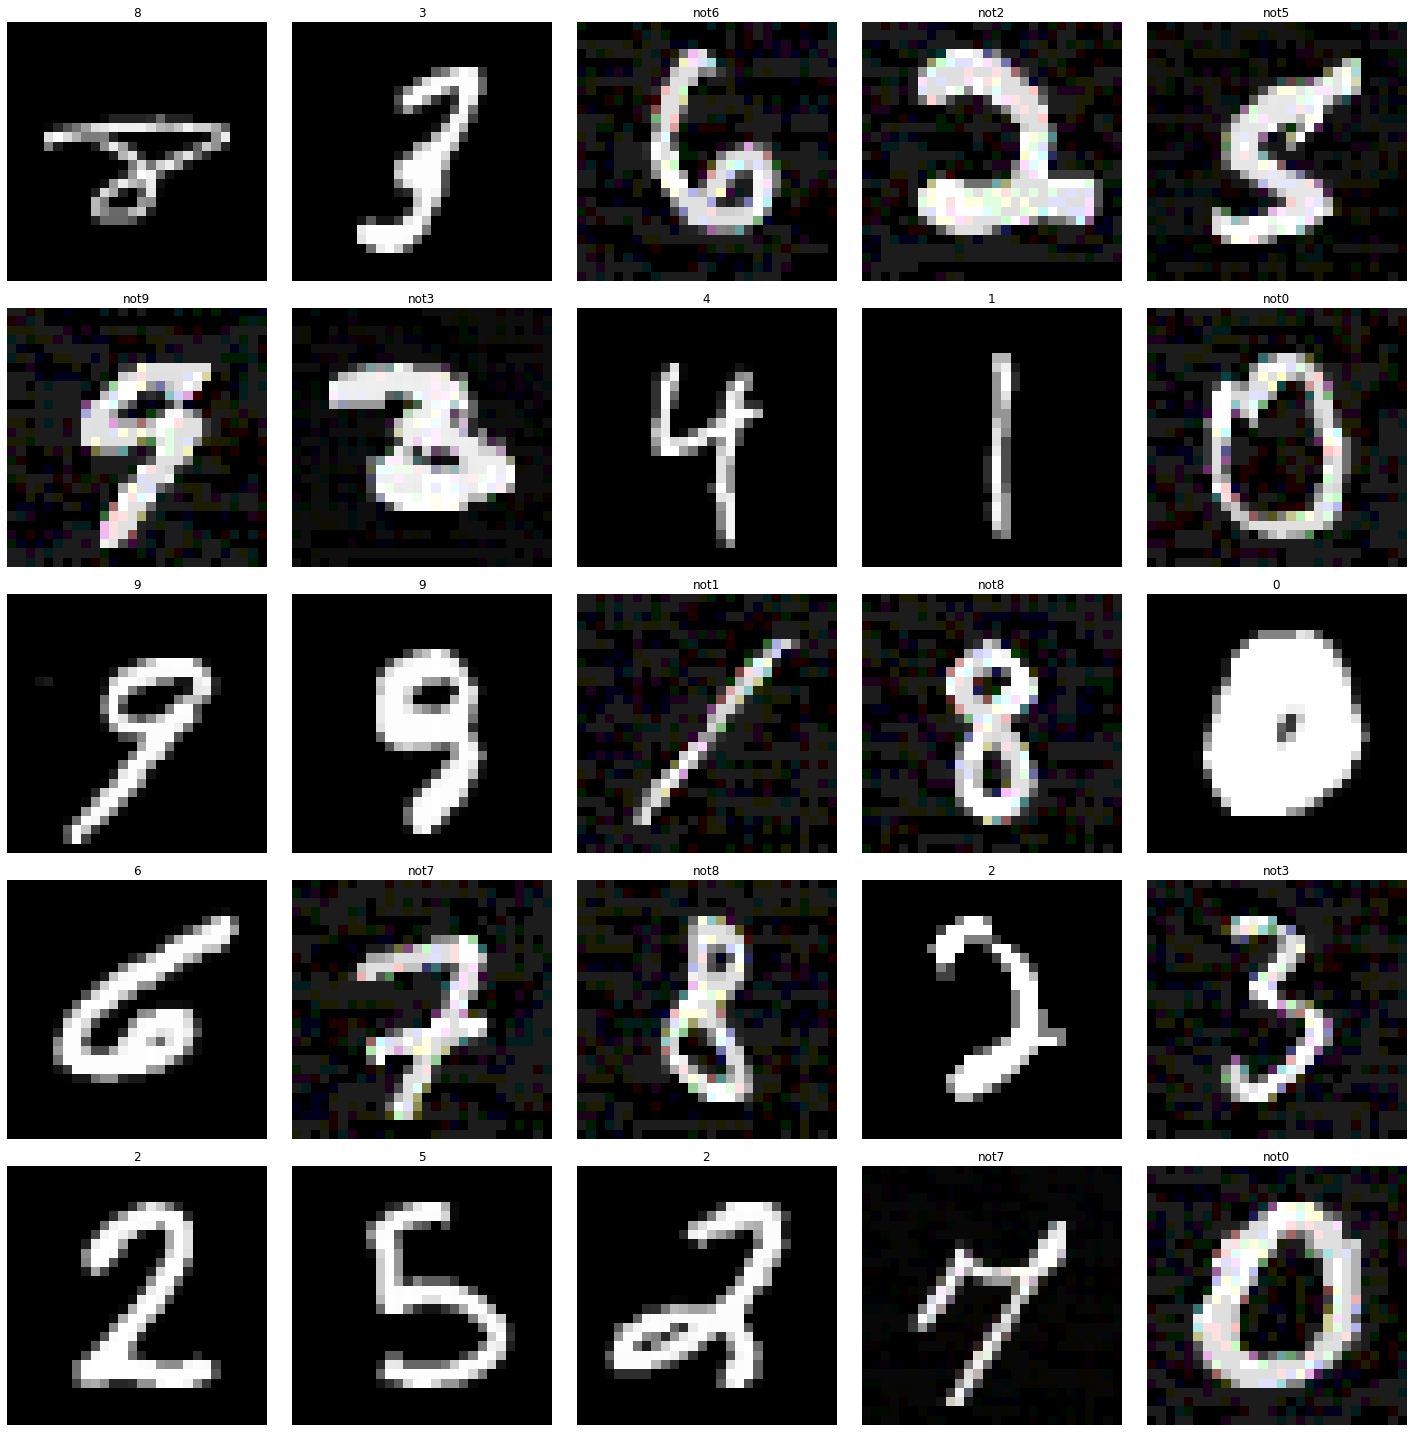

In [9]:
from fastai.vision.data import ImageDataBunch
data = ImageDataBunch.from_folder(mnist_path.parent/'mnist_or_fgsm', train='training', valid='testing', size=28, bs=128)
data.show_batch()